In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
#import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
#from classy import Class
%matplotlib inline
#import s1 
import ST
from scipy.integrate import trapz
from scipy.integrate import dblquad, quad
import scipy
import sys
import spherical
import quaternionic
import sympy as sym 

In [2]:

def beam2bl(beam, lmax, sigma, freq):
    """Computes a transfer (or window) function b(l) in spherical
    harmonic space from its circular beam profile b(theta) in real
    space.
    Parameters
    ----------
    beam : array
        Circular beam profile b(theta).
    theta : array
        Radius at which the beam profile is given. Has to be given
        in radians with same size as beam.
    lmax : integer
        Maximum multipole moment at which to compute b(l).
    Returns
    -------
    bl : array
        Beam window function b(l).
    """

    #nx = len(theta)
    #nb = len(beam)
    #if nb != nx:
    #    raise ValueError("Beam and theta must have same size!")

    cos = lambda x: np.cos(x)
    st = lambda x: np.sin(x)
    window = np.zeros(lmax + 1, dtype = np.complex128)

    p0 = lambda x: 1
    
    

    
    y = lambda x, sigma, freq: st(x) * beam(x, sigma, freq) *p0(x)
    
    def real_func (x,sigma, freq):
        return np.real (y(x, sigma, freq))
    
    def imag_func ( x,sigma, freq):
        return np.imag (y(x,sigma, freq))
    
    window[0] = (quad(real_func, a=0, b=np.pi, args= (sigma, freq))[0]+ 1.j * quad(imag_func, a=0, b=np.pi, args = (sigma, freq))[0]) #trapz(beam * p0 * st, theta)
    
    p1 = lambda x: cos(x)
    y = lambda x, sigma, freq: st(x) * beam(x, sigma, freq) * p1(x)
    
    def real_func (x,sigma, freq):
        return np.real (y(x, sigma, freq))
    
    def imag_func ( x,sigma, freq):
        return np.imag (y(x,sigma, freq))
    
    window[1] = (quad(real_func, a=0, b=np.pi, args= (sigma, freq))[0]+ 1.j*quad(imag_func, a=0, b=np.pi, args = (sigma, freq))[0])
    for l in np.arange(2, lmax + 1):
        print (l)
        p2 = lambda x : x * p1(x) * (2 * l - 1) / l - p0(x) * (l - 1) / l
        y = lambda x, sigma, freq: st(x) * beam(x, sigma, freq) * p2(x)
        def real_func (x,sigma, freq):
            return np.real (y(x, sigma, freq))
    
        def imag_func ( x,sigma, freq):
            return np.imag (y(x,sigma, freq))
        
        window[l] = (quad(real_func, a=0, b=np.pi, args= (sigma, freq))[0]+ 1.j*quad(imag_func, a=0, b=np.pi, args = (sigma, freq))[0])
        p0 = p1
        p1 = p2

    window *= 2 * np.pi
    return window



In [3]:

def beam2alm(beam, Theta, Phi, lmax):
    """Computes a transfer (or window) function b(l) in spherical
    harmonic space from its circular beam profile b(theta) in real
    space.
    Parameters
    ----------
    beam : array
        Circular beam profile b(theta).
    theta : array
        Radius at which the beam profile is given. Has to be given
        in radians with same size as beam.
    lmax : integer
        Maximum multipole moment at which to compute b(l).
    Returns
    -------
    bl : array
        Beam window function b(l).
    """
   
    """    
    x = np.cos(theta)
    st = np.sin(theta)
    almsize = hp.Alm.getsize(lmax)
    window = np.zeros(almsize, dtype = np.complex128)

    p0 = np.ones(nx)
    p1 = np.copy(x)

    window[0] = trapz(beam * p0 * st, theta)
    window[1] = trapz(beam * p1 * st, theta)
    ind = hp.Alm.getidx(lmax, 1, 1)
    window[ind] = trapz(beam * -st * st, theta)

    for l in np.arange(2, lmax + 1):

        p2 = x * p1 * (2 * l - 1) / l - p0 * (l - 1) / l
        #window[l] = trapz(beam * p2 * st, theta)
        #p0 = p1
        #p1 = p2
        
        tmp = p2
        for m in range (0, l+1):
            
            print (l,m)
            ind = hp.Alm.getidx(lmax, l, m)
            q = np.diff(tmp)/np.diff(x[:nx-m])
            Theta, Phi = np.meshgrid(theta[:-m-1], phi[:-m-1])
            print ("doen")
            list1=func(Theta, Phi, sigma, freq, phi0)
            print (list1.shape)
            list1 *=  (np.sin(Theta))**m * (-1)**m * np.sin (Theta) * np.exp (1.j*m*Phi)
            int_exp2d = np.trapz(np.trapz(list1, phi[:-m-1], axis=0), theta[:-m-1], axis=0)
            
            window[ind] = int_exp2d
            tmp = q
            
        p0 = p1
        p1 = p2 
    """           



    almsize = hp.Alm.getsize(lmax)
    window = np.zeros(almsize, dtype = np.complex128)

    #Theta, Phi = np.meshgrid(theta, phi)
    theta = Theta [0,:]
    phi = Phi[:,0]
    meas = np.sin (Theta)
    for l in range (lmax+1):
        
        for m in range (l+1):
            
            ind = hp.Alm.getidx(lmax, l, m)
            
            ylmc = scipy.special.sph_harm(m , l, Phi, Theta).conjugate()
            
            window[ind] = np.trapz(np.trapz(beam * ylmc * meas, phi, axis=0), theta, axis=0)

            
        
    return window


In [ ]:

def beam2alm_map(beam,  lmax):
    """Computes a transfer (or window) function b(l) in spherical
    harmonic space from its circular beam profile b(theta) in real
    space.
    Parameters
    ----------
    beam : array
        Circular beam profile b(theta).
    theta : array
        Radius at which the beam profile is given. Has to be given
        in radians with same size as beam.
    lmax : integer
        Maximum multipole moment at which to compute b(l).
    Returns
    -------
    bl : array
        Beam window function b(l).
    """
   
    """    
    x = np.cos(theta)
    st = np.sin(theta)
    almsize = hp.Alm.getsize(lmax)
    window = np.zeros(almsize, dtype = np.complex128)

    p0 = np.ones(nx)
    p1 = np.copy(x)

    window[0] = trapz(beam * p0 * st, theta)
    window[1] = trapz(beam * p1 * st, theta)
    ind = hp.Alm.getidx(lmax, 1, 1)
    window[ind] = trapz(beam * -st * st, theta)

    for l in np.arange(2, lmax + 1):

        p2 = x * p1 * (2 * l - 1) / l - p0 * (l - 1) / l
        #window[l] = trapz(beam * p2 * st, theta)
        #p0 = p1
        #p1 = p2
        
        tmp = p2
        for m in range (0, l+1):
            
            print (l,m)
            ind = hp.Alm.getidx(lmax, l, m)
            q = np.diff(tmp)/np.diff(x[:nx-m])
            Theta, Phi = np.meshgrid(theta[:-m-1], phi[:-m-1])
            print ("doen")
            list1=func(Theta, Phi, sigma, freq, phi0)
            print (list1.shape)
            list1 *=  (np.sin(Theta))**m * (-1)**m * np.sin (Theta) * np.exp (1.j*m*Phi)
            int_exp2d = np.trapz(np.trapz(list1, phi[:-m-1], axis=0), theta[:-m-1], axis=0)
            
            window[ind] = int_exp2d
            tmp = q
            
        p0 = p1
        p1 = p2 
    """           

    nside = hp.get_nside(beam)

    almsize = hp.Alm.getsize(lmax)
    window = np.zeros(almsize, dtype = np.complex128)

    #Theta, Phi = np.meshgrid(theta, phi)
    theta = Theta [0,:]
    phi = 
    meas = np.sin (Theta)
    for l in range (lmax+1):
        
        for m in range (l+1):
            
            ind = hp.Alm.getidx(lmax, l, m)
            
            ylmc = scipy.special.sph_harm(m , l, Phi, Theta).conjugate()
            
            window[ind] = np.trapz(np.trapz(beam * ylmc * meas, phi, axis=0), theta, axis=0)

            
        
    return window


In [4]:
def integrate (beam, sigma, freq):
    #nx = len(theta)
    #nb = len(beam)
    #if nb != nx:
    #    raise ValueError("Beam and theta must have same size!")
        
    

    #x = np.cos(theta)
    st =  lambda x: np.sin(x)
    y = lambda x, sigma, freq: st(x) * beam(x, sigma, freq)
    #window = np.zeros(lmax + 1, dtype = np.complex128)

    #p0 = np.ones(nx)
    #p1 = np.copy(x)
    
    def real_func (x, sigma, freq):
        return np.real (y(x, sigma, freq))
    
    def imag_func (x, sigma, freq):
        return np.imag (y(x, sigma, freq))
    
    real_integral = quad(real_func, a=0, b=np.pi, args= (sigma, freq))
    imag_integral = quad(imag_func, a=0, b=np.pi, args = (sigma, freq))

    ans = 2 * np.pi * (real_integral[0] + 1j*imag_integral[0])
    #err = (real_integral[1:], imag_integral[1:])
    
    
    return ans 


In [5]:
def integrate_dir (beam, sigma, freq, phi0):
    #nx = len(theta)
    #nb = len(beam)
    #if nb != nx:
    #    raise ValueError("Beam and theta must have same size!")
        
    

    #x = np.cos(theta)
    st =  lambda x: np.sin(x)
    y = lambda x, t, sigma, freq, phi0: st(x) * beam(x, t, sigma, freq, phi0)
    #window = np.zeros(lmax + 1, dtype = np.complex128)

    #p0 = np.ones(nx)
    #p1 = np.copy(x)
    
    def real_func (x, t, sigma, freq, phi0):
        return np.real (y(x, t, sigma, freq, phi0))
    
    def imag_func (x, t, sigma, freq, phi0):
        return np.imag (y(x, t, sigma, freq, phi0))
    
    real_integral = dblquad(real_func, a=0, b=2*np.pi, gfun=0, hfun=np.pi, args= (sigma, freq, phi0))
    imag_integral = dblquad(imag_func, a=0, b=2*np.pi, gfun=0, hfun=np.pi, args= (sigma, freq, phi0))

    ans =  (real_integral[0] + 1j*imag_integral[0])
    #err = (real_integral[1:], imag_integral[1:])
    
    
    return ans 


In [6]:
def integrate_2nd (beam, theta):
    nx = len(theta)
    nb = len(beam)
    #ny = len(phi)
    if nb != nx:
        raise ValueError("Beam and theta must have same size!")

    #x = np.cos(theta)
    st = np.sin(theta)
    #window = np.zeros(lmax + 1, dtype = np.complex128)

    #p0 = np.ones(nx)
    #p1 = np.copy(x)

    ans = trapz(beam * st, theta)
    #ans_phi = trapz(p0,dx = 2*np.pi/nb )
    
    
    return ans 


In [7]:
def integrate_dir_2nd (beam, Theta, Phi):
    nx = len(Theta)
    nb = len(beam)
    ny = len(Phi)
    if nb != nx:
        raise ValueError("Beam and theta must have same size!")

    #x = np.cos(theta)
    #window = np.zeros(lmax + 1, dtype = np.complex128)

    
    theta = Theta [0,:]
    phi = Phi[:,0]
    st = np.sin(Theta)
    
    int_2d = np.trapz(np.trapz(beam * st, phi, axis=0), theta, axis=0)
    
    
    return int_2d 


In [8]:
def gabor(theta, sigma, freq):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g



def morlet (theta, sigma, freq):
    wv=gabor(theta, sigma, freq)
    wvm=gabor(theta, sigma, 0)
    B=integrate(gabor, sigma, freq)/integrate(gabor, sigma, 0)
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    return mor




def morlet_2nd (theta, sigma, freq):
    wv=gabor(theta, sigma, freq)
    wvm=gabor(theta, sigma, 0)
    B=integrate_2nd(wv, theta)/integrate_2nd(wvm, theta)
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    return mor

 

def morlet_arr (resol, jmax, theta_arr) :
    mor=[]
    fl2beam=[]
    
    #theta=np.linspace(0,np.pi,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet (theta_arr, sigma1, freq1)
        #print ("ok")
        #norm = np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin)
        #morf /= norm
        #print ("okk")
        #mor_l = beam2bl(morf, theta, lmax)
        #norm = np.sqrt(np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin))
        #print ("hello")
        mor.append(morf)
    
    return mor


def morlet_arr_2nd (resol, jmax, theta_arr) :
    mor=[]
    fl2beam=[]
    
    #theta=np.linspace(0,np.pi,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet_2nd (theta_arr, sigma1, freq1 )
        #print ("ok")
        #norm = np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin)
        #morf /= norm
        #print ("okk")
        #mor_l = beam2bl(morf, theta, lmax)
        #norm = np.sqrt(np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin))
        #print ("hello")
        mor.append(morf)
    
    return mor



In [9]:
def gabor_prj(freq,sigma,theta):
    
    arg=-(4*np.tan(theta/2)**2)/(2*sigma*sigma) + 2.j * freq*np.tan(theta/2)
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g


def morlet_prj (f, sigma, theta, lmax):
    wv=gabor_prj(f,sigma,theta)
    wvm=gabor_prj(0,sigma, theta)
    B=integrate(wv/(1+np.cos(theta)),theta)/integrate(wvm/(1+np.cos(theta)),theta)
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    print ("hihi")
    return mor


 

def morlet_arr_prj (resol, jmax, lmax, theta_bin) :
    morl=[]
    fl2beam=[]
    
    theta=np.linspace(0,np.pi-0.0001,theta_bin)
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        morf = morlet_prj (freq1, sigma1, theta, lmax)
        #print ("ok")
        #norm = np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin)
        #morf /= norm
        #print ("okk")
        mor_l = beam2bl(morf, theta, lmax)
        #norm = np.sqrt(np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin))
        #print ("hello")
        morl.append(mor_l)
    
    return morl



In [10]:
def convolve_dir (field_l, wavelet_l, lmax, theta_arr , phi_arr):
    wigner = spherical.Wigner(lmax)
    R = quaternionic.array.from_spherical_coordinates(theta_arr, phi_arr)
    D = wigner.D(R)
    h = np.zeros(len(theta_arr))
    print (D.shape)
    for l in range (lmax):
        for m_f in range (0,l+1):
            ind_f = hp.Alm.getidx(lmax, l, m_f)
            for m_w in range (0,l+1):
                ind_w = hp.Alm.getidx(lmax, l, m_w)
                ind_D = wigner.Dindex(l, m_w, m_f)
                
                h+=np.real(D[:,ind_D]*field_l [ind_f]*wavelet_l[ind_w])
                print ("okok")
                ind_Dp = wigner.Dindex(l, -m_w, -m_f)
                h+=np.real(D[:,ind_Dp]*field_l [ind_f].conjugate()*wavelet_l[ind_w].conjugate())
                
                
    return h 
                
  

In [39]:
def gabor_dir(theta, phi, sigma, freq, phi0):
    
    arg=(-(theta**2)/(2*sigma*sigma) )+( 1.j * freq*theta* np.cos(phi-phi0))
    
    g=np.exp(arg)
    g/=2*np.pi*sigma*sigma
    return g


def morlet_dir (theta, phi, sigma, freq, phi0):
    wv=gabor_dir(theta, phi, sigma, freq, phi0)
    wvm=gabor_dir(theta, phi, sigma, 0, phi0)
    B=integrate_dir_2nd(wv, theta, phi)/integrate_dir_2nd(wvm, theta, phi)
    mor=wv-B*wvm
    #norm = np.mean(np.abs(mor)**2*np.sin(theta))
    #mor = mor/norm
    return mor


 

def morlet_arr_dir (Theta, Phi, resol, jmax, rmax, nside, lmax) :
    mor=[]
    fl2beam=[]
    r = np.linspace (0,np.pi, rmax+1)[:-1]
    
    theta = Theta [0,:]
    phi = Phi[:,0]
    pix = hp.ang2pix(nside, Theta, Phi)
    
    #Theta , Phi = np.meshgrid(theta_arr, phi_arr)
    #theta_arr , phi_arr = hp.pix2ang(nside, np.arange (npix))
    for j in range(jmax):
        sigma1 = (0.8*resol*2**j)
        freq1=(3.0*np.pi) /(4.0*resol*2**j)
        for phi0 in r:
            print (j, phi0)
            
            mor_map = np.zeros(hp.nside2npix(nside) , dtype="float")
            
            morf = morlet_dir (Theta, Phi, sigma1, freq1, phi0)
            #print ("ok")
            #norm = np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin)
            #morf /= norm
            #print ("okk")
            mor_map[pix] = morf 
            #norm = np.sqrt(np.sum((np.abs (morf))**2 * np.sin(theta)*np.pi/theta_bin))
            #print ("hello")
            mor.append(mor_map)

    return mor





In [12]:

def compS1_dir (hmap, mor_arr, jmax, rmax, nside, gaus_l = None , lmax = None , resol = None):

    if lmax == None :
        lmax = 3 * nside - 1 
    
    if resol==None :
        resol = hp.nside2resol(nside, arcmin =False )
        
    
    S1=np.zeros((jmax*rmax))
    i1=[]
    
    mapalm=hp.map2alm(hmap, lmax =lmax)
    
    npix = hp.nside2npix (nside)
    theta_arr , phi_arr = hp.pix2ang(nside, np.arange (npix))
    
    
    
    #mor_l = morlet_arr(resol, jmax, lmax, jbin)
    #gaus_l = gaus_arr(resol, jmax, jbin)
    
    for j in range(jmax*rmax):
        print(j)
        
        #morlet filter 
        
        morl = mor_arr[j]
        #morl = hp.map2alm(morf, lmax)
        
        #convolving the map with filter 1
        
        #I1 = convolve_dir (mapalm, morl, lmax, theta_arr , phi_arr)
       
        nalm=hp.almxfl(mapalm,morl)
        
        I1=hp.alm2map(nalm, nside, lmax)
        

        #modulus
        I1=np.abs(I1)

        i1.append(I1)
        #Gaussian filter for S1
        
        
        
        if gaus_l == None:
            
            S1map = I1
            
        else:
        
            gausl = gaus_l[j]
            #Convolving with gaussian filter to get S1
            I1alm=hp.map2alm(I1, lmax, use_pixel_weights=True)
            
            nI1alm=hp.almxfl(I1alm, gausl)
        
            S1map=hp.alm2map(nI1alm, nside, lmax)
        
    
        #Averaging the entire map
        S1[j]=np.mean(S1map)
        
    return S1 , i1

In [13]:
map_dust= hp.read_map ("/Users/arefe/Projects/ScatteringTransform/COM_CompMap_dust-commander_0256_R2.00.fits")

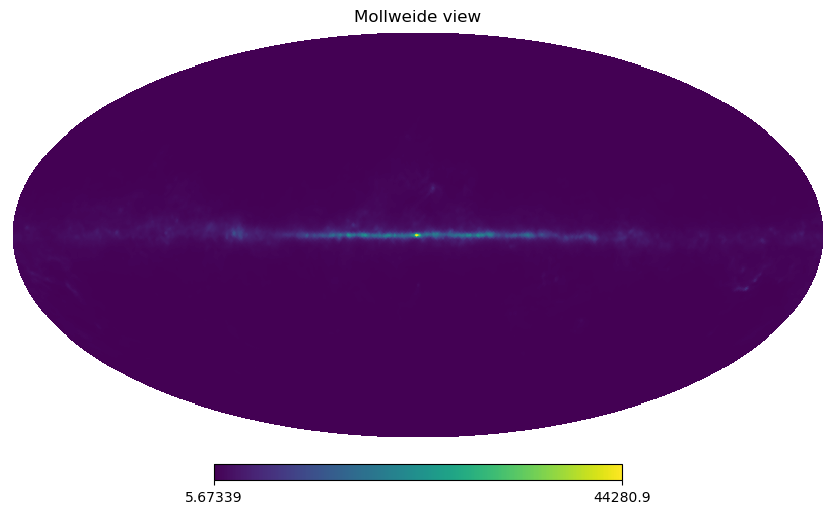

In [14]:
hp.mollview(map_dust)

In [15]:
nside = 256
lmax = 3*nside -1 
res_rad = hp.nside2resol(nside, arcmin = False)
res_arcmin = hp.nside2resol(nside, arcmin = True)

In [16]:
ell = np.arange(0,lmax+1)
ellsc = 21600/ell
norm= ell * (ell+1) / (2*np.pi)

/var/folders/vj/5ltjqv9d4px7nr3d4mbmk9_m0000gn/T/ipykernel_4471/2172233455.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc = 21600/ell


In [17]:
mapsize = hp.nside2npix(nside)
almsize = hp.Alm.getsize(lmax)

In [18]:

jmax = 9
rmax = 4

In [19]:
dust_map = hp.ud_grade(map_dust, nside)

In [52]:
theta_lin = np.linspace(0,np.pi, 5000)
phi_lin = np.linspace (0, 2*np.pi, 5000)



Theta, Phi = np.meshgrid(theta_lin, phi_lin)


In [53]:
mor_arr = morlet_arr_dir(Theta, Phi, res_rad, jmax, rmax, nside, 50)

0 0.0


/var/folders/vj/5ltjqv9d4px7nr3d4mbmk9_m0000gn/T/ipykernel_4471/2498574109.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  mor_map[pix] = morf


0 0.7853981633974483
0 1.5707963267948966
0 2.356194490192345
1 0.0
1 0.7853981633974483
1 1.5707963267948966
1 2.356194490192345
2 0.0
2 0.7853981633974483
2 1.5707963267948966
2 2.356194490192345
3 0.0
3 0.7853981633974483
3 1.5707963267948966
3 2.356194490192345
4 0.0
4 0.7853981633974483
4 1.5707963267948966
4 2.356194490192345
5 0.0
5 0.7853981633974483
5 1.5707963267948966
5 2.356194490192345
6 0.0
6 0.7853981633974483
6 1.5707963267948966
6 2.356194490192345
7 0.0
7 0.7853981633974483
7 1.5707963267948966
7 2.356194490192345
8 0.0
8 0.7853981633974483
8 1.5707963267948966
8 2.356194490192345


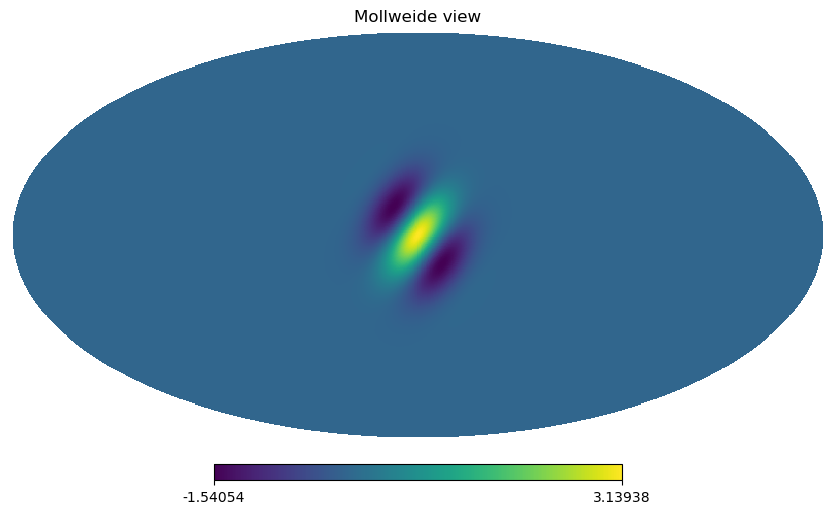

In [64]:
hp.mollview(mor_arr[27], rot = [0, 90])

In [70]:
hp.map2alm(mor_arr[32])

array([-8.75575865e-05+0.00000000e+00j,  5.65823988e-02+0.00000000e+00j,
        1.03711584e-01+0.00000000e+00j, ...,
        1.42944990e-07-1.46244879e-08j,  1.73645575e-09-1.40325161e-09j,
       -1.55575899e-07-8.90827350e-09j])

In [64]:
s1, i1 = compS1_dir(dust_map, mor_arr, jmax, rmax, nside, lmax=lmax)

47
ehem
0
(3072, 147440)
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
5
(3072, 147440)
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
oko

okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok
okok


KeyboardInterrupt: 

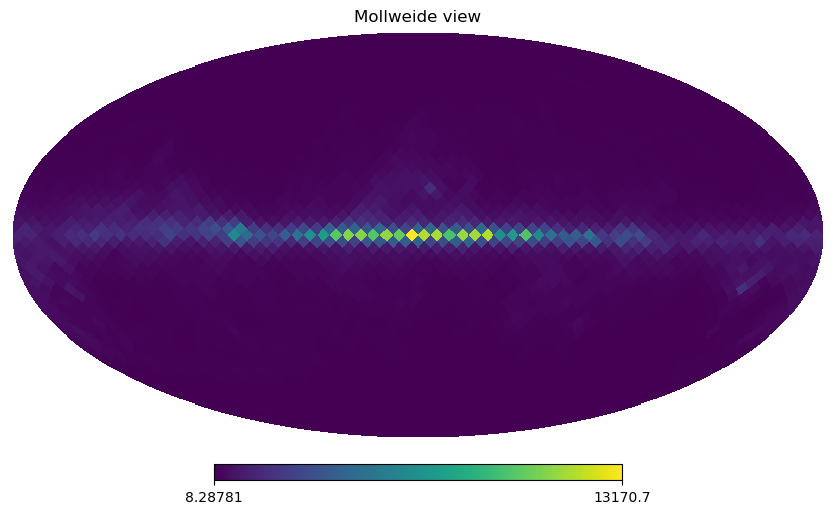

In [59]:
hp.mollview(dust_map)

In [60]:
hp.map2alm(dust_map)

array([ 1.21195856e+03 +0.j        , -1.33327397e+01 +0.j        ,
       -1.12929667e+03 +0.j        , ...,  2.07938561e+01 +2.08560537j,
        3.80460011e-01 -2.15108066j, -9.30765607e+00-10.04224281j])

In [56]:
theta_arr , phi_arr = hp.pix2ang(nside, np.arange (mapsize))

In [42]:
theta_arr.shape

(12288,)

In [292]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(12):
    plt.plot(ell,hp.beam2bl(mor_arr[j],theta_arr, lmax),label='j='+str(j))
    #plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

NameError: name 'mor_arr' is not defined

<Figure size 2000x800 with 0 Axes>

In [364]:
mor_arr_sym = morlet_arr (res_rad, jmax, theta_arr)
print ("ok")
#mor_arr_sym_2nd = morlet_arr_2nd (res_rad, jmax, theta_arr)

ok


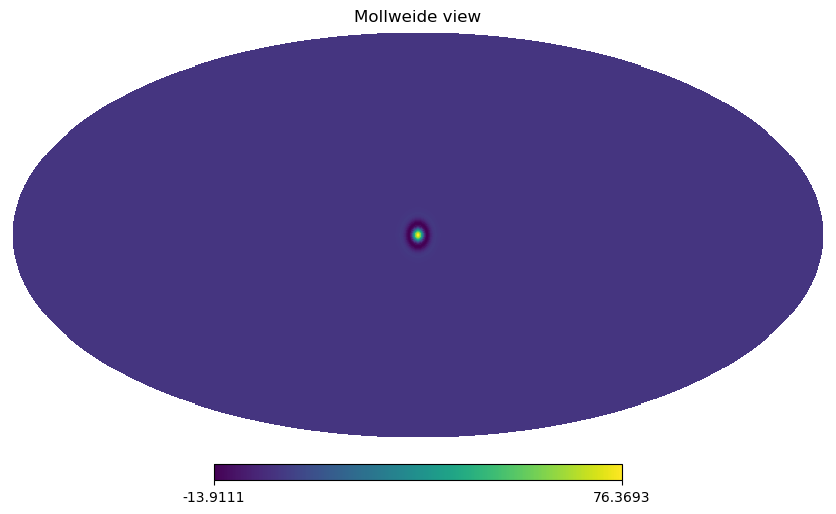

In [370]:
hp.mollview(mor_arr_sym[4], rot=[0,90])

In [58]:
mor_arr_sym_2nd[5]

array([1.92278192e+001-6.10305447e+000j, 1.92278192e+001-6.10193615e+000j,
       1.92278190e+001-6.10081781e+000j, ...,
       1.72832542e-204+1.90492078e-204j, 1.72601622e-204+1.90270079e-204j,
       1.72371007e-204+1.90048335e-204j])

/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1354: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1359: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


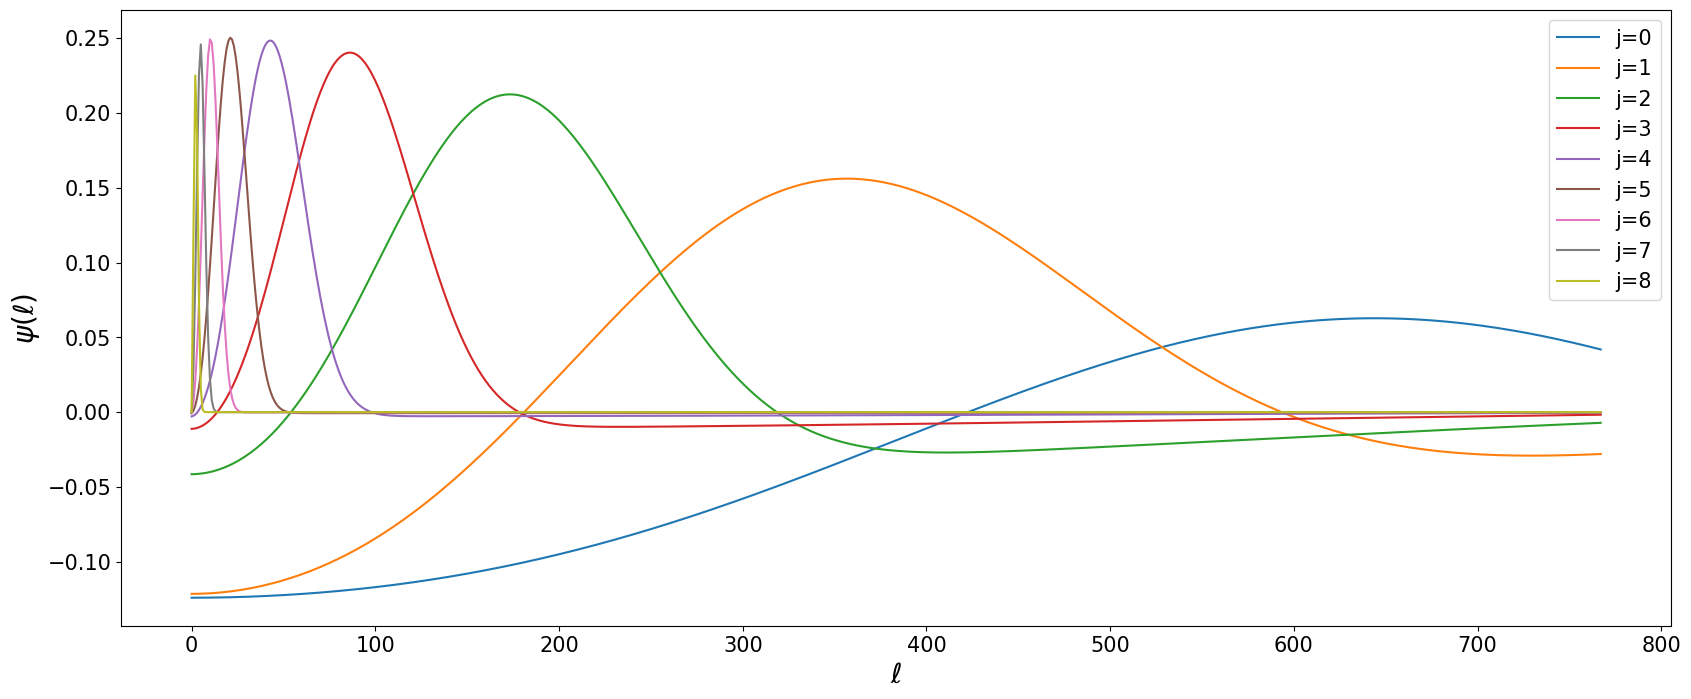

In [249]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,np.real(hp.beam2bl(mor_arr_sym[j],theta_arr, lmax)),label='j='+str(j))
    #plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1354: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1359: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


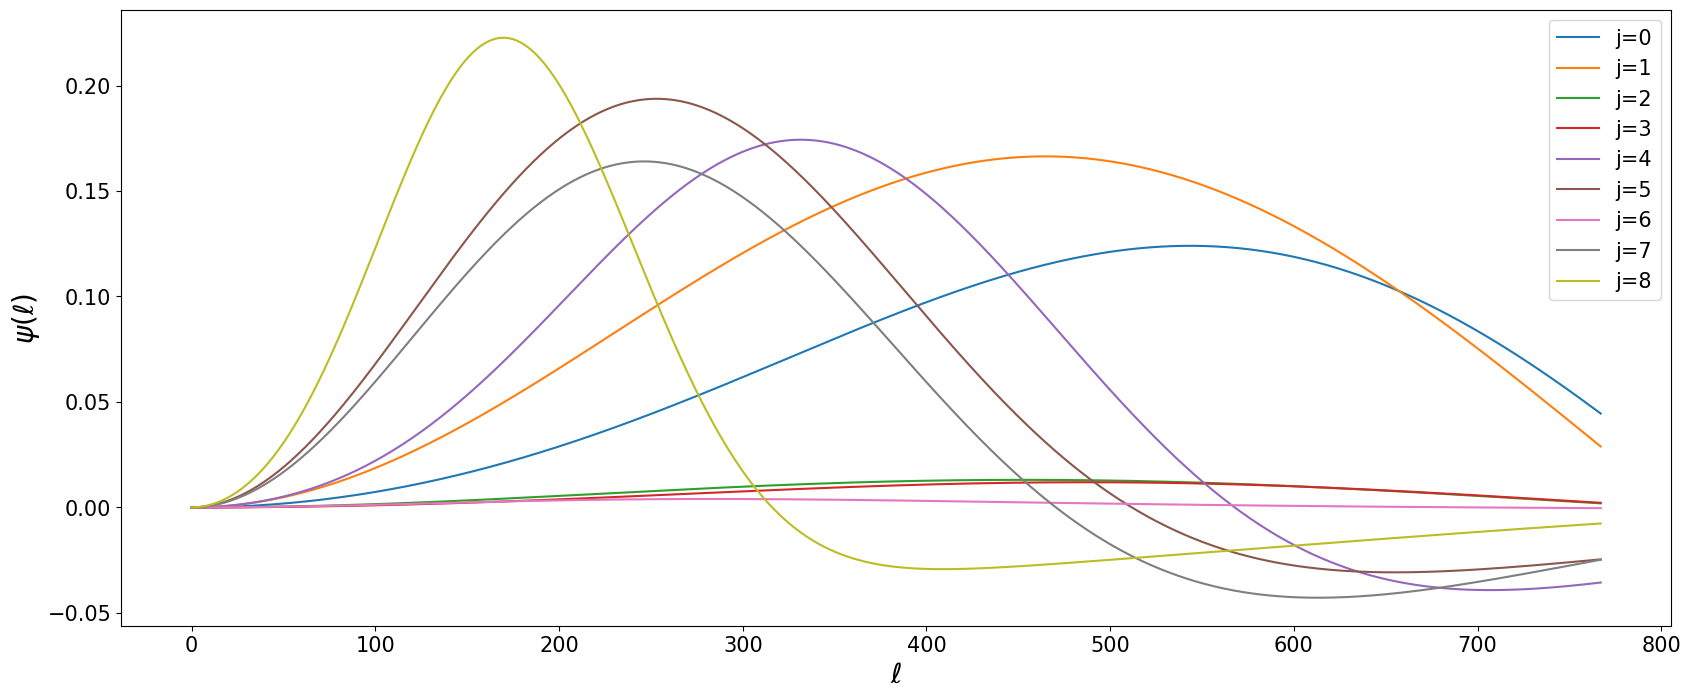

In [57]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,np.real(hp.beam2bl(mor_arr[j],theta_arr, lmax)),label='j='+str(j))
    #plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1354: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1359: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


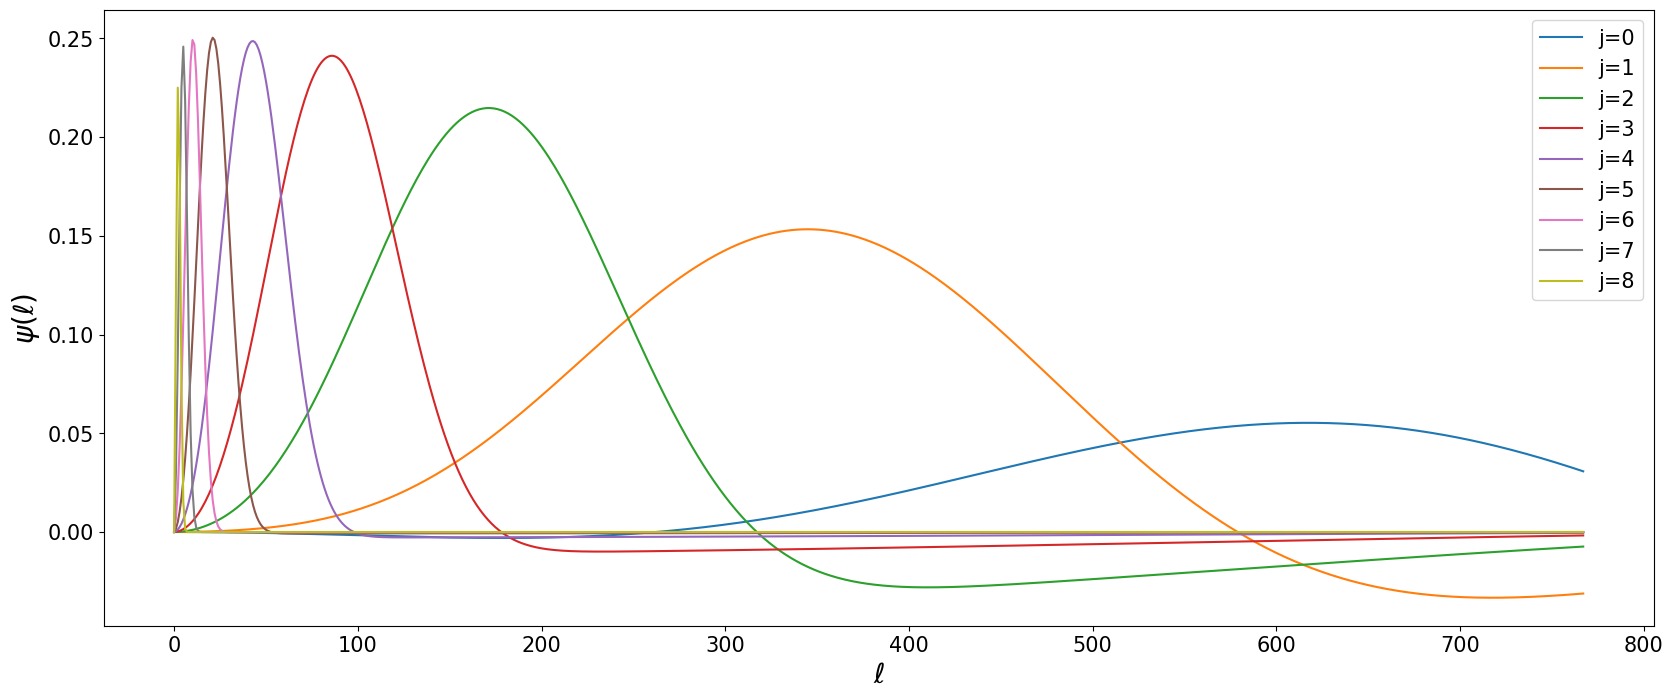

In [260]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,np.real(hp.beam2bl(mor_arr_sym_2nd[j],theta_arr, lmax)),label='j='+str(j))
    #plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1354: ComplexWarning: Casting complex values to real discards the imaginary part
  window[0] = trapz(beam * p0 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  window[1] = trapz(beam * p1 * st, theta)
/Users/arefe/opt/anaconda3/envs/envhealpy/lib/python3.8/site-packages/healpy/sphtfunc.py:1359: ComplexWarning: Casting complex values to real discards the imaginary part
  window[l] = trapz(beam * p2 * st, theta)


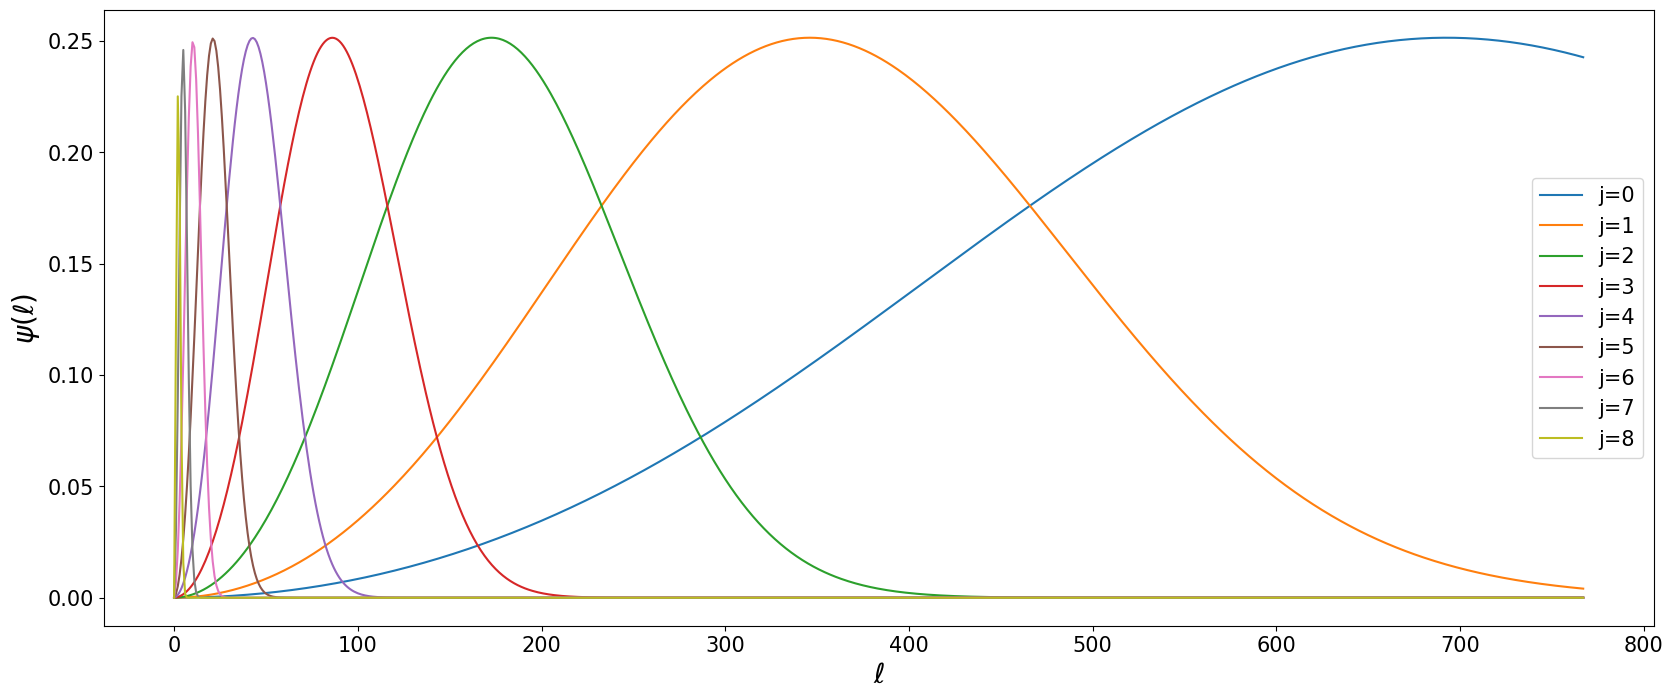

In [108]:
ell = np.arange (lmax+1)
fig=plt.figure(figsize=[20,8])
for j in range(jmax):
    plt.plot(ell,np.real(hp.beam2bl(mor_arr_sym_2nd[j],np.linspace(0,np.pi, 786432), lmax)),label='j='+str(j))
    #plt.plot(ell,np.real(morlet_l_arr[j]),label='j='+str(j))
    plt.legend(prop={'size': 15})
    
#plt.yscale("log")
plt.xlabel("$\ell$", size=20)
plt.ylabel("$\psi(\ell)$", size=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig("profile.pdf")

In [92]:
theta_arr

array([0.00318944, 0.00318944, 0.00318944, ..., 3.13840321, 3.13840321,
       3.13840321])

In [93]:
np.linspace(0,np.pi, 786432)

array([0.00000000e+00, 3.99474671e-06, 7.98949343e-06, ...,
       3.14158466e+00, 3.14158866e+00, 3.14159265e+00])

In [64]:
phi_arr

array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
       5.49778714])

In [105]:
np.linspace(0,np.pi, 786432)

array([0.00000000e+00, 3.99474671e-06, 7.98949343e-06, ...,
       3.14158466e+00, 3.14158866e+00, 3.14159265e+00])

In [106]:
np.pi/786432

3.994741635118857e-06

In [111]:
ans_phi = trapz(np.ones(1000),dx = 2*np.pi/1000 )
ans_phi

6.276902121872405

In [241]:
import scipy
integrate (gabor, 0.001,0.001)

(0.9999996666657321+1.2533135106579697e-06j)

In [233]:
wv_lin=gabor(np.linspace(0,np.pi, 786432), 0.001, 0.001)
integrate_3rd(wv_lin, np.linspace(0,np.pi, 786432))

(0.9999983368312293+1.2533135106579614e-06j)


(0.9999983368312293+1.2533135106579614e-06j)

In [232]:
wv_arr=gabor(theta_arr, 0.001, 0.001)
integrate_3rd(wv_arr, theta_arr)

(0.03143852232994041+1.0027141061752446e-07j)


(0.03143852232994041+1.0027141061752446e-07j)

(0.0, 0.5)

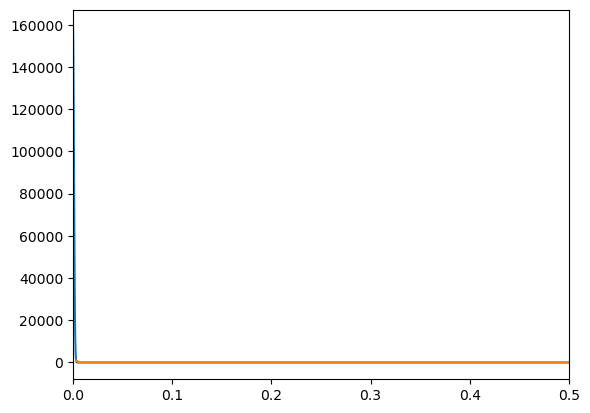

In [236]:
plt.plot(np.linspace(0,np.pi, 786432), wv_lin)
plt.plot (theta_arr, wv_arr)
plt.xlim(0,0.5)

In [206]:
np.linspace(0,np.pi, 786432)

array([0.00000000e+00, 3.99474671e-06, 7.98949343e-06, ...,
       3.14158466e+00, 3.14158866e+00, 3.14159265e+00])

In [203]:
theta_arr

array([0.00318944, 0.00318944, 0.00318944, ..., 3.13840321, 3.13840321,
       3.13840321])

In [202]:
wv_lin

array([159154.9430919 +0.j        , 159153.67319957+0.00063578j,
       159149.86358337+0.00127153j, ...,      0.        +0.j        ,
            0.        +0.j        ,      0.        +0.j        ])

In [199]:
wv_arr

array([983.74445098+0.0031376j, 983.74445098+0.0031376j,
       983.74445098+0.0031376j, ...,   0.        +0.j       ,
         0.        +0.j       ,   0.        +0.j       ])

In [208]:
gabor (0.00318944, 1, 1)

(0.15915332409072006+0.000507611699220399j)

In [209]:
gabor (3.99474671e-06, 1, 1)

(0.15915494308935557+6.357836852898224e-07j)

In [261]:
p0 = lambda x : x**2

In [262]:
p1 = p0

In [264]:
p1(6)

36

In [95]:
alm = np.zeros (almsize, dtype = np.complex128)
alm[0:10] = 1

beam = hp.alm2map(alm, nside )




In [96]:
beam2alm(beam, Theta, Phi, lmax)

ValueError: operands could not be broadcast together with shapes (786432,) (100,100) 